In [2]:
from extractor import *

from algo_spam import *

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier

import os.path
from os import path

import matplotlib.pyplot as plt
import numpy as np


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saeny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saeny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saeny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
link_datafolder = "./../../../checkdatasets/"

dataset = import_email_data(link_folder=link_datafolder)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_set = remove_duplicates(train_set, remove_dups=True, print_dups=False)
train_set = remove_missing_vals(train_set, remove_missing=True, print_missing=False)


FileNotFoundError: [Errno 2] File b'./../../../checkdatasets/enronSpamSubset.csv' does not exist: b'./../../../checkdatasets/enronSpamSubset.csv'

In [ ]:
pickle_name    = "datasets_optimum_clean"
force_repickle = False
if path.exists(link_datafolder+pickle_name) and (not force_repickle):
    print("realoading cleaned dataset\n")
    [train_set_clean, 
     test_set_clean] = pickle_data(link_folder=link_datafolder, 
                                    name=pickle_name, operation="rb")
else:
    print("pickling cleaned dataset\n")
    train_set_clean = prep_mails(train_set['Body'])
    test_set_clean = prep_mails(test_set['Body'])
    pickle_data(data_item=[train_set_clean, 
                           test_set_clean], link_folder=link_datafolder, 
                name=pickle_name, operation="wb")

In [ ]:
train_set_copy = train_set

In [ ]:
vectorizer_bow ,train_vec, test_vec =\
create_vectorizer(train_set_clean, test_set_clean, max_features=500)

[train_vec, train_set] = remove_outlyers(train_vec, train_set_copy, threshold=100)

# KNN

In [ ]:
def perform_knn(neighbors, **kwargs):
    accuracy_test  = []
    accuracy_train = []
    for n in neighbors:
        knn = create_knn(train_vec, train_set['Label'], n_neighbors=n,**kwargs)
        rep_test, rep_train = get_metrics(knn, test_vec[:1000], test_set['Label'][:1000], train_vec[:1000], train_set['Label'][:1000])
        accuracy_test.append(rep_test['accuracy'])
        accuracy_train.append(rep_train['accuracy'])
    print(accuracy_test)
    print(accuracy_train)
    plt.plot(neighbors,accuracy_test)
    plt.plot(neighbors,accuracy_train)
    plt.show()

In [4]:
perform_knn(neighbors=np.arange(1,11,1))
perform_knn(neighbors=np.arange(1,11,1), weights='distance')
perform_knn(neighbors=np.arange(1,11,1), weights='distance',p=1)

NameError: name 'perform_knn' is not defined

Plot 2 shows if we use distance weights and 8 neighbors the trainset score lowers but the testset score improves.

In [5]:
knn = create_knn(train_vec, train_set['Label'], n_neighbors=8,weights='distance')
rep_test, rep_train = get_metrics(knn, test_vec, test_set['Label'], train_vec, train_set['Label'])


print(rep_test['accuracy'])
print(rep_train['accuracy'])

NameError: name 'train_vec' is not defined

# perceptron

In [6]:
param_grid = {'eta0': [0.1,0.2,0.3,0.4],  
              'early_stopping': [True, False],
              'max_iter':[10,20,30,100],
              'tol':[1e-4,1e-3,1e-2,1e-1]}  
print(train_vec)
ppn = create_perceptron(train_vec, train_set['Label'], grid=param_grid)
print(ppn.best_params_) 
ppn = create_perceptron(train_vec, train_set['Label'], **ppn.best_params_)

NameError: name 'train_vec' is not defined

In [64]:

ppn = create_perceptron(train_vec, train_set['Label'], eta0=0.3,early_stopping=False, max_iter=10,tol=1e-4)
rep_test, rep_train = get_metrics(ppn, test_vec, test_set['Label'], train_vec, train_set['Label'])

print(rep_test['accuracy'])
print(rep_train['accuracy'])

0.9440698135660452
0.9526037428803905


/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


# Decision Tree

In [65]:
dtree = create_decisiontree(train_vec, train_set['Label'], random_state=42)
rep_test, rep_train = get_metrics(dtree, test_vec, test_set['Label'], train_vec, train_set['Label'])

print(rep_test['accuracy'])
print(rep_train['accuracy'])


0.9163030543435144
0.9977624084621644


In [66]:
path = dtree.cost_complexity_pruning_path(train_vec, train_set['Label'])
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

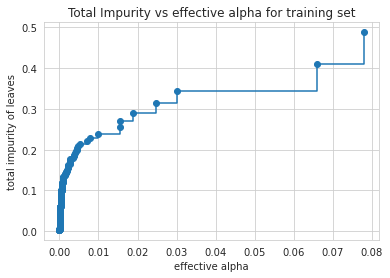

In [67]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [73]:
clfs = []
ccp_alphas = [1e-5,1e-4,2e-4,3e-4,5e-4,1e-3,1e-2,1e-1]
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(train_vec, train_set['Label'])
    clfs.append(clf)

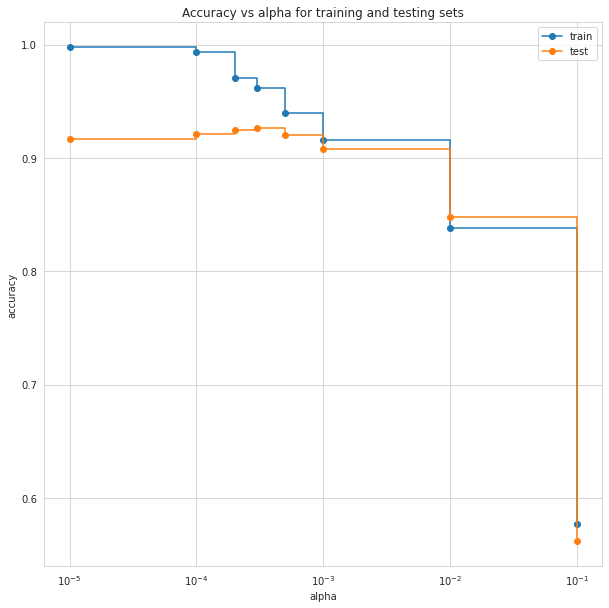

In [74]:
train_scores = [clf.score(train_vec, train_set['Label']) for clf in clfs]
test_scores = [clf.score(test_vec, test_set['Label']) for clf in clfs]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.semilogx(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.semilogx(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [75]:
dtree = create_decisiontree(train_vec, train_set['Label'], random_state=42, ccp_alpha=1e-4)
rep_test, rep_train = get_metrics(dtree, test_vec, test_set['Label'], train_vec, train_set['Label'])

print(rep_test['accuracy'])
print(rep_train['accuracy'])

0.9214597381991273
0.9935923515052889


# Random Forrest

In [76]:
dtree = create_rnd_forrest(train_vec, train_set['Label'], random_state=42,ccp_alpha=1e-4)
rep_test, rep_train = get_metrics(dtree, test_vec, test_set['Label'], train_vec, train_set['Label'])


print(rep_test['accuracy'])
print(rep_train['accuracy'])

0.9674732249107497
0.9919650122050447


In [77]:
dtree = create_rnd_forrest(train_vec, train_set['Label'], random_state=42,max_leaf_nodes=40)
rep_test, rep_train = get_metrics(dtree, test_vec, test_set['Label'], train_vec, train_set['Label'])

print(rep_test['accuracy'])
print(rep_train['accuracy'])

0.9452598175327251
0.942839707078926


In [78]:
ccp_alphas = [1e-5,1e-4,2e-4,3e-4,5e-4,1e-3,1e-2,1e-1]
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, criterion="entropy")
    clf.fit(train_vec, train_set['Label'])
    clfs.append(clf)

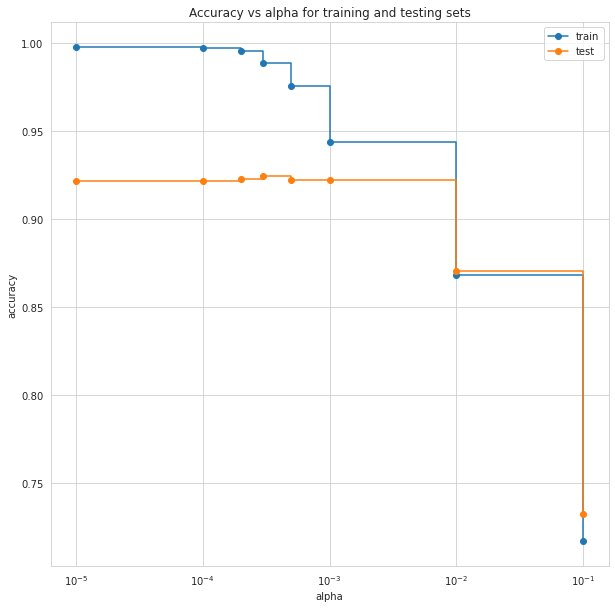

In [79]:
train_scores = [clf.score(train_vec, train_set['Label']) for clf in clfs]
test_scores = [clf.score(test_vec, test_set['Label']) for clf in clfs]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.semilogx(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.semilogx(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [80]:
param_grid = {'criterion': ["gini", "entropy"]}  
rndf = create_rnd_forrest(train_vec, train_set['Label'],grid=param_grid,ccp_alpha=3e-4)
print(rndf.best_params_) 

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'criterion': 'gini'}


In [82]:
dtree = create_rnd_forrest(train_vec, train_set['Label'], random_state=42,ccp_alpha=5e-4, criterion="entropy")
rep_test, rep_train = get_metrics(dtree, test_vec, test_set['Label'], train_vec, train_set['Label'])


print(rep_test['accuracy'])
print(rep_train['accuracy'])

0.96390321301071
0.9826078112286412


# Naive Bayes

In [83]:
nb = create_nb(train_vec, train_set['Label'])
rep_test, rep_train = get_metrics(nb, test_vec, test_set['Label'], train_vec, train_set['Label'])


print(rep_test['accuracy'])
print(rep_train['accuracy'])

0.9309797699325665
0.93053295362083


In [84]:
param_grid = {'criterion': ["gini", "entropy"]}  
rndf = create_rnd_forrest(train_vec, train_set['Label'],grid=param_grid,ccp_alpha=3e-4)
print(rndf.best_params_) 

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'criterion': 'entropy'}


# Summary

In [55]:
test_scores = []
train_scores = []
features = [100, 200, 400, 800, 1000, 1200, 1400, 1600]
for max_features in features:
    vectorizer_bow ,train_vec, test_vec =\
    create_vectorizer(train_set_clean, test_set_clean, max_features=max_features)
    [train_vec, train_set] = remove_outlyers(train_vec, train_set_copy, threshold=100)
    
    knn = create_knn(train_vec, train_set['Label'], n_neighbors=8,weights='distance')
    ppn = create_perceptron(train_vec, train_set['Label'], eta0=0.3,early_stopping=False, max_iter=10,tol=1e-4)
    dtree = create_decisiontree(train_vec, train_set['Label'], random_state=42, ccp_alpha=1e-4)
    dtree1 = create_rnd_forrest(train_vec, train_set['Label'], random_state=42,ccp_alpha=5e-4, criterion="entropy")
    nb = create_nb(train_vec, train_set['Label'])
    clfs = [knn, ppn, dtree, dtree1, nb]
    #print(max_features)
    for clf in clfs:
        rep_test, rep_train = get_metrics(clf, test_vec, test_set['Label'], train_vec, train_set['Label'])
        #print(clf)
        #print(rep_test['accuracy'])
        #print(rep_train['accuracy'])
        test_scores.append(rep_test['accuracy'])
        train_scores.append(rep_train['accuracy'])
    

removing 37 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 37 rows

removing 38 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 41 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


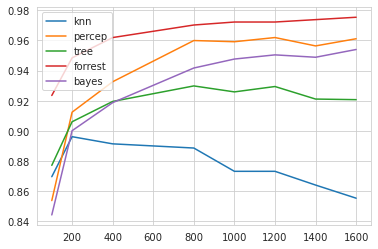

In [56]:
labels = ["knn","percep","tree","forrest","bayes"]
for n, label in enumerate(labels):
    plt.plot(features,np.array(test_scores).reshape(-1,5)[:,n],label=label)
plt.legend(loc="best")

In [87]:
test_scores = []
train_scores = []
features = [100,500,1000,1500,2000,2500,3000,3500,4000,4500]
for max_features in features:
    vectorizer_bow ,train_vec, test_vec =\
    create_vectorizer(train_set_clean, test_set_clean, max_features=max_features)
    [train_vec, train_set] = remove_outlyers(train_vec, train_set_copy, threshold=100)
    
    ppn = create_perceptron(train_vec, train_set['Label'], eta0=0.3,early_stopping=False, max_iter=10,tol=1e-4)
    dtree = create_decisiontree(train_vec, train_set['Label'], random_state=42, ccp_alpha=1e-4)
    dtree1 = create_rnd_forrest(train_vec, train_set['Label'], random_state=42,ccp_alpha=5e-4, criterion="entropy")
    nb = create_nb(train_vec, train_set['Label'])
    clfs = [ ppn, dtree, dtree1, nb]
    #print(max_features)
    for clf in clfs:
        rep_test, rep_train = get_metrics(clf, test_vec, test_set['Label'], train_vec, train_set['Label'])
        #print(clf)
        #print(rep_test['accuracy'])
        #print(rep_train['accuracy'])
        test_scores.append(rep_test['accuracy'])
        train_scores.append(rep_train['accuracy'])

removing 37 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 38 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


removing 43 rows



/home/fabian/.conda/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


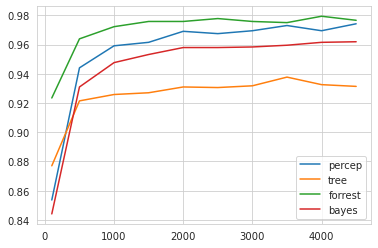

In [89]:
labels = ["percep","tree","forrest","bayes"]
for n, label in enumerate(labels):
    plt.plot(features,np.array(test_scores).reshape(-1,4)[:,n],label=label)
plt.legend(loc="best")